<a href="https://colab.research.google.com/github/s-choung/Research_utility/blob/main/Fitting_excel_generator_221123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error 

def func(x, a, b):
    return a*x + b

df = pd.read_excel('/content/Fitting_raw.xlsx')
df

,t,CO,CO2
0,2687.99,0.00204,0.000715
1,2691.86,0.00407,0.000916
2,2695.74,0.00467,0.001070
3,2699.61,0.00511,0.001160
4,2703.49,0.00525,0.001130
...,...,...,...
437,4254.61,0.01206,0.000058
438,4258.23,0.01198,0.000056
439,4261.86,0.01191,0.000063
440,4265.48,0.01196,0.000062


In [137]:
def fitting_data_generator(k_in,L0_in):
  dt=df['t'][1]-df['t'][0]
  df['P_CO*dt'] = df['CO']*dt

  co2_corr=0.000183474482420675
  df['P_CO2_corr'] = df['CO2']-co2_corr
  df['P_CO2*dt'] = df['P_CO2_corr']*dt
  #####initial
  k=k_in
  L0=L0_in
  #####Active sites number  
  df['r_actsites']=df['P_CO*dt']
  df['r_actsites'][0]=df['P_CO*dt'][0]*k*L0

  for i in range(1,len(df['P_CO2*dt'])):
    L=L0-df.loc[0:i-1,['r_actsites']].sum(axis = 0)
    df['r_actsites'][i]=df['P_CO*dt'][i]*k*L
  df['r_actsites_accumul']=df['r_actsites'].cumsum()
  df['actsites_num']=L0-df['r_actsites_accumul']

  df['P_CO2*dt_model']=k*df['actsites_num']*df['P_CO*dt']
  df['exp_model_diff']=df['P_CO2*dt']-df['P_CO2*dt_model']
#  df['variance']=df['exp_model_diff']**2
#  std_dev=df['exp_model_diff'].std()
  MAE=mean_absolute_error(df['P_CO2*dt'], df['P_CO2*dt_model'])
  MSE=mean_squared_error(df['P_CO2*dt'], df['P_CO2*dt_model'])

  return df, MAE, MSE


In [147]:
k=2.02743630482588
L0=0.0969205276275516
df2, mae, mse =fitting_data_generator(k,L0)
df2
df2.to_excel('Fitting_added.xls', index=False)
print(mae,mse)

0.00020416037632444063 6.726622340074012e-08


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """


In [142]:
df2

,t,CO,CO2,P_CO*dt,P_CO2_corr,P_CO2*dt,r_actsites,r_actsites_accumul,actsites_num,P_CO2*dt_model,exp_model_diff
0,2687.99,0.00204,0.000715,0.007895,0.000531,0.002055,0.001551,0.001551,9.536920e-02,1.526499e-03,0.000529
1,2691.86,0.00407,0.000916,0.015751,0.000732,0.002833,0.003046,0.004597,9.232368e-02,2.948260e-03,-0.000115
2,2695.74,0.00467,0.001070,0.018073,0.000887,0.003431,0.003383,0.007980,8.894079e-02,3.258938e-03,0.000172
3,2699.61,0.00511,0.001160,0.019776,0.000977,0.003779,0.003566,0.011546,8.537480e-02,3.423015e-03,0.000356
4,2703.49,0.00525,0.001130,0.020318,0.000947,0.003663,0.003517,0.015063,8.185800e-02,3.371931e-03,0.000291
...,...,...,...,...,...,...,...,...,...,...,...
437,4254.61,0.01206,0.000058,0.046672,-0.000126,-0.000487,0.000000,0.096921,5.551115e-17,5.252738e-18,-0.000487
438,4258.23,0.01198,0.000056,0.046363,-0.000127,-0.000492,0.000000,0.096921,5.551115e-17,5.217894e-18,-0.000492
439,4261.86,0.01191,0.000063,0.046092,-0.000120,-0.000465,0.000000,0.096921,5.551115e-17,5.187405e-18,-0.000465
440,4265.48,0.01196,0.000062,0.046285,-0.000122,-0.000470,0.000000,0.096921,5.551115e-17,5.209183e-18,-0.000470


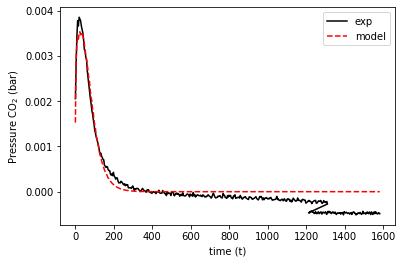

In [140]:
rel_t=df2['t']-df2['t'][0]

plt.plot(rel_t,df2['P_CO2*dt'],color='black',label='exp')
plt.plot(rel_t,df2['P_CO2*dt_model'],color='red',label='model',linestyle='dashed')

plt.xlabel('time (t)')
plt.ylabel('Pressure CO$_{2}$ (bar)')
plt.legend()


In [149]:
'''def opti_k_L0_finder(k_ini,k_fin,L0_ini,L0_fin):
  mae_list=[]
  mse_list=[]
  mae_data=pd.DataFrame()
  mse_data=pd.DataFrame()
  for i in range(k_ini,k_fin):
    for j in range(L0_ini,L0_fin):
     df, mae, mse = fitting_data_generator(i,j)
     mae_list.append(mae)
     mse_list.append(mse)
     mae_data['L0'][i][j]=j
     mae_data['mae'][i][j]=mae
  return mae_data
opti_k_L0_finder(2,3,)
print(mae_data)
'''

NameError: ignored